# Lesson 12 Exercise

In [7]:
# Rodrigo Almeida, Ping
# Team Dragon Masters
# 24/01/2017

# Import modules
import os
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly, GDT_Float32
import numpy as np
import urllib
import tarfile

# Set working directory to path of main.py
working_path = os.path.dirname(os.path.realpath("__file__"))
os.chdir(working_path)

# Create data folder if not exists
if not os.path.exists('data'):
    os.makedirs('data')
    
# Download and unzip files
url = "https://www.dropbox.com/s/zb7nrla6fqi1mq4/LC81980242014260-SC20150123044700.tar.gz?dl=1"
urllib.urlretrieve (url,"data/LC8.tar.gz")
tar = tarfile.open("data/LC8.tar.gz")
tar.extractall("data/LC8")
lc8 = tar.getnames()
tar.close()

# Removes the tar file
os.remove("data/LC8.tar.gz")

# Creates a list of the necessary files and opens them
data_source = []
# elem 0 is 4, elem 1 is 5
lc8_4_5 = filter(lambda s: re.match(r".*band[45].tif",s), lc8)
for fl in lc8_4_5:
    data_source += [gdal.Open('data/LC8/'+fl, GA_ReadOnly)]

# Define the function to derive NDWI
def ndwi(band4,band5):
    return (band4-band5)/(band4+band5)
    
# Read data into array
ds_array = []
for ds in data_source:
    ds_array += [ds.GetRasterBand(1).ReadAsArray(0,0,ds.RasterXSize, ds.RasterYSize)]

# Set the data type
ds_array[0] = ds_array[0].astype(np.float32)
ds_array[1] = ds_array[1].astype(np.float32)

# Derive the NDWI, mask for denominator > 0
mask = np.greater(ds_array[0]+ds_array[1],0)

# set np.errstate to avoid warning of invalid values (i.e. NaN values) in the divide 
with np.errstate(invalid='ignore'):
    ndwi = np.choose(mask,(-99,ndwi(ds_array[0],ds_array[1])))

# Write the result to disk
driver = gdal.GetDriverByName('GTiff')
outDataSet = driver.Create('data/ndwi.tif', data_source[0].RasterXSize, data_source[0].RasterYSize, 1, GDT_Float32)
outBand = outDataSet.GetRasterBand(1)
outBand.WriteArray(ndwi,0,0)
outBand.SetNoDataValue(-99)

# set the projection and extent information of the dataset
outDataSet.SetProjection(data_source[0].GetProjection())
outDataSet.SetGeoTransform(data_source[0].GetGeoTransform())

# Finally let's save it... or like in the OGR example flush it
outBand.FlushCache()
outDataSet.FlushCache()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in divide


This script saves the calculated NDWI into data/ndwi.tif.   
__Now we will use a bash command to reproject the file, into lat long. __ 

In [5]:
!gdalwarp -t_srs "EPSG:4326" data/ndwi.tif data/ndwi_ll.tif

Processing input file data/ndwi.tif.
Using internal nodata values (e.g. -99) for image data/ndwi.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


__Displays the resulting file__

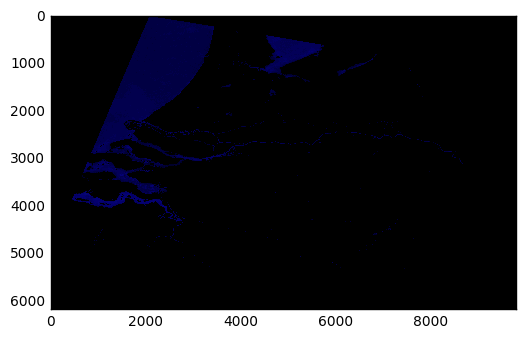

In [6]:
# Notebook magic to select the plotting method
# Change to inline to plot within this notebook 
from osgeo import gdal
import matplotlib.pyplot as plt
# Open image
dsll = gdal.Open("data/ndwi_ll.tif")

# Read raster data
ndwi = dsll.ReadAsArray(0, 0, dsll.RasterXSize, dsll.RasterYSize)

# Now plot the raster data using gist_earth palette
plt.imshow(ndwi, interpolation='nearest', vmin=0, cmap=plt.cm.gist_earth)
plt.show()

dsll = None